# End-to-End Regression Project 

**Dataset:** we will use many dataset and all of them will be suitable for this project and each one : (10,000 rows).

**Flow:** EDA → Preprocessing → Modeling  → Evaluation → Simple streamlit app.



## 0) Imports & Settings
Why? We'll use pandas/numpy for data, matplotlib for plotting, and scikit-learn for preprocessing & models.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib



## 1) Load Data


In [9]:
df = pd.read_csv("car_prices.csv")
df.head()

,mileage_km,is_automatic,engine_size_l,brand,age_years,price
0,133712.0,No,1.0,Honda,9.0,12836.90636
1,73201.0,NaN,3.0,BMW,2.0,26638.32267
2,153770.0,No,3.0,BMW,1.0,22383.97603
3,162325.0,Yes,3.0,NaN,5.0,22190.69594
4,32203.0,Yes,2.0,nissan,2.0,26949.07820


## 2) Quick EDA
Why? Understand shape, dtypes, missingness, and basic distributions. This guides preprocessing and modeling choices.

In [10]:
# Shape & dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mileage_km     9527 non-null   float64
 1   is_automatic   9503 non-null   object 
 2   engine_size_l  9492 non-null   float64
 3   brand          9463 non-null   object 
 4   age_years      9536 non-null   float64
 5   price          10000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 468.9+ KB


In [11]:
# Basic stats for numeric columns
df.describe()

,mileage_km,engine_size_l,age_years,price
count,9527.000000,9492.000000,9536.000000,10000.000000
mean,121378.282460,1.841972,7.924811,16529.228454
std,49145.476462,0.655891,3.441916,3916.996246
min,5000.000000,1.000000,0.000000,2458.276012
25%,89906.500000,1.000000,6.000000,13940.448358
50%,119899.000000,2.000000,8.000000,16493.530340
75%,150113.500000,2.000000,10.000000,19059.572105
max,562240.000000,6.000000,20.000000,38475.630480


In [12]:
# Missing values overview
df.isna().sum().sort_values()

price              0
age_years        464
mileage_km       473
is_automatic     497
engine_size_l    508
brand            537
dtype: int64

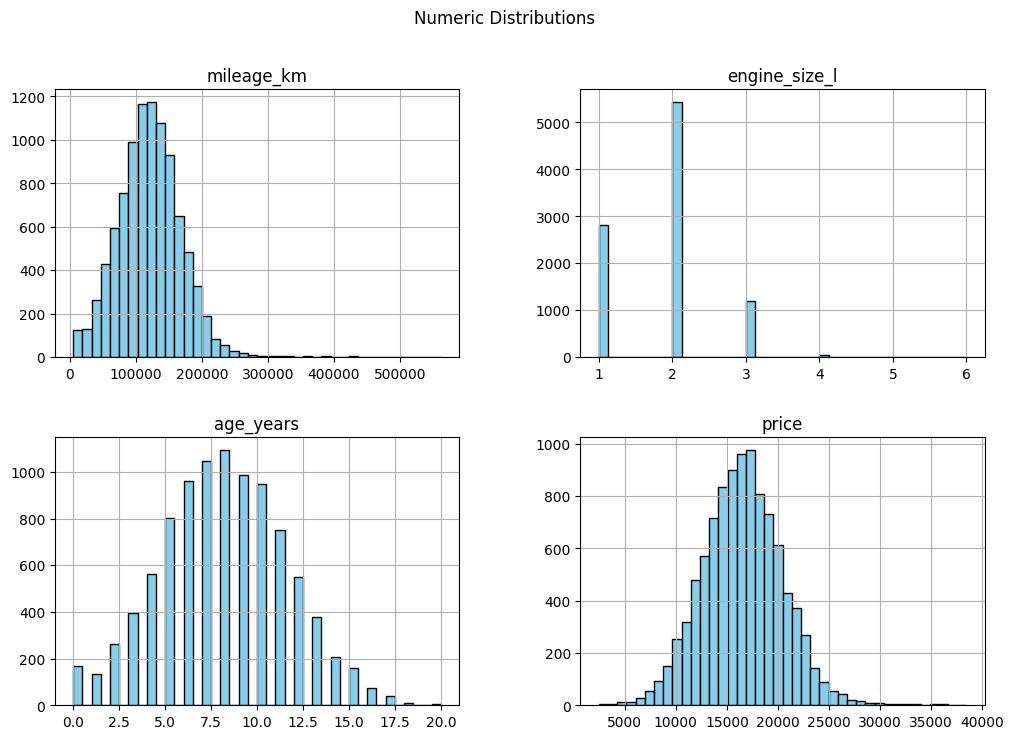

In [29]:
# Histograms for numeric features
numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
ax = df[numeric_cols].hist(bins=40, figsize=(12,8),color='skyblue', edgecolor='black')
plt.suptitle('Numeric Distributions')
plt.show() 

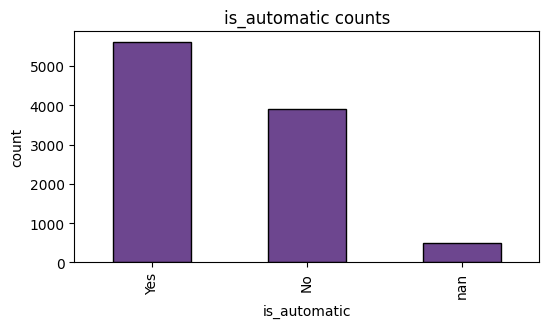

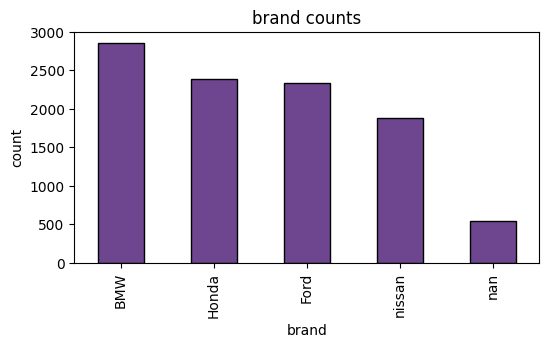

In [36]:
# Bar plots for categorical counts
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    df[c].value_counts(dropna=False).plot(kind='bar', figsize=(6,3), color="#6D468F", edgecolor='black')
    plt.title(f'{c} counts')
    plt.xlabel(c)
    plt.ylabel('count')
    plt.show()

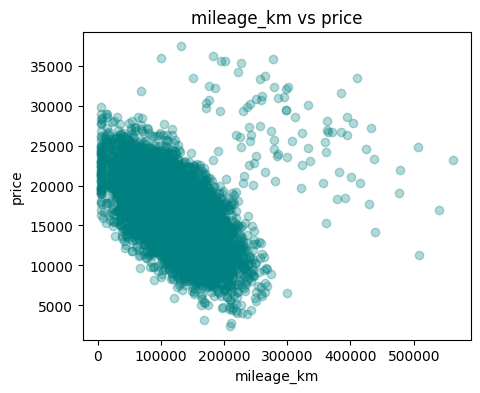

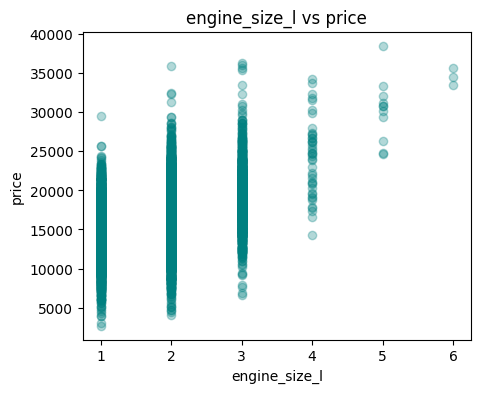

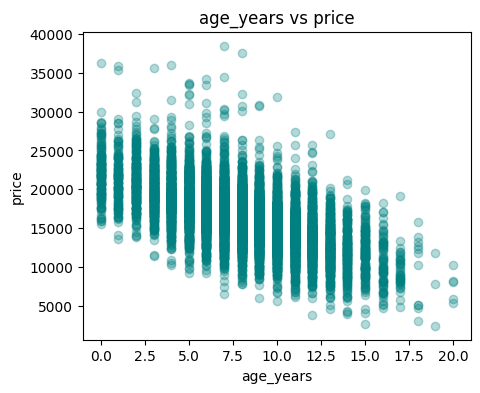

In [37]:
# Scatter plots: numeric features vs target
target  = df.columns[-1]
for c in [col for col in numeric_cols if col != target]:
    plt.figure(figsize=(5,4))
    plt.scatter(df[c], df[target], alpha=0.3, color='teal')
    plt.xlabel(c)
    plt.ylabel(target)
    plt.title(f'{c} vs {target}')
    plt.show()

## 3) Train / Test Split
Why? Honest evaluation requires holding out a test set not seen during training.

In [16]:
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((8000, 5), (2000, 5))

## 4) Preprocessing with ColumnTransformer + Pipeline
Why? Different types need different transforms (impute & scale numerics; impute & one-hot-encode categoricals). Pipelines keep it clean and prevent leakage.

In [17]:
numeric_features = X.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## 5) Baseline: Linear Regression
Why? A simple baseline helps us gauge whether added complexity is worth it.

In [38]:
lr_pipe = Pipeline([
    ('prep', preprocess),
    ('model', LinearRegression())
])
lr_pipe.fit(X_train, y_train)
pred_lr = lr_pipe.predict(X_test)
mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = mean_squared_error(y_test, pred_lr)
r2_lr = r2_score(y_test, pred_lr)
print(f'Linear Regression - MAE: {mae_lr:.2f}, R2: {r2_lr:.4f}')


Linear Regression - MAE: 1196.90, R2: 0.7709


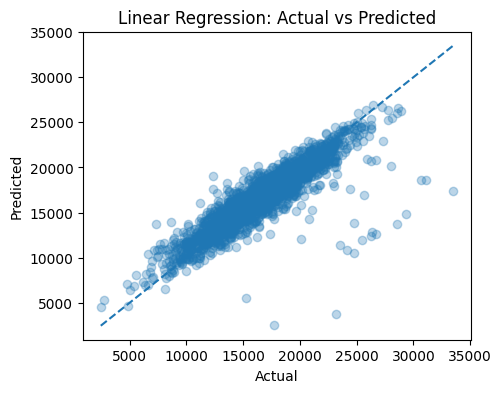

In [19]:
# Residuals & Pred vs Actual

plt.figure(figsize=(5,4))
plt.scatter(y_test, pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

SHAP analysis complete. Plotting results...


Global Feature Importance (Bar Plot):


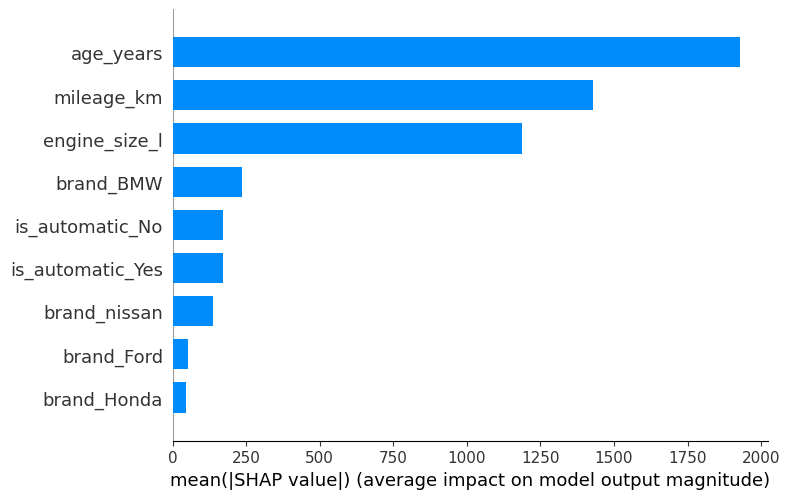


Global Feature Importance (Beeswarm Plot):


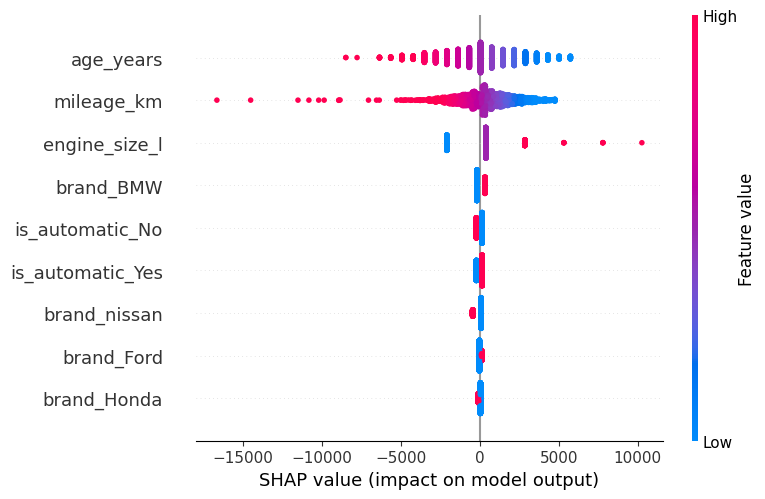


SHAP Waterfall Plot for Test Sample Index 0:


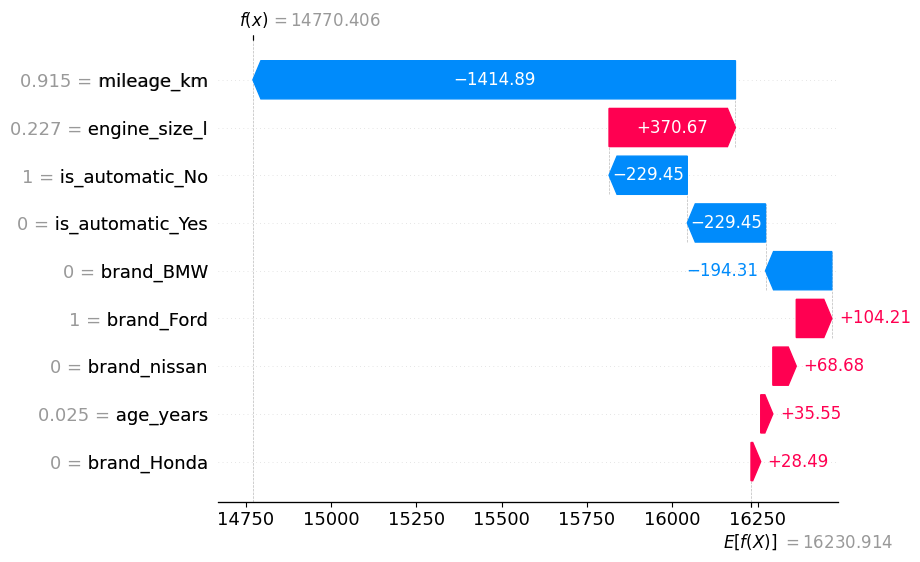

In [20]:
import shap

# 1. Get the preprocessor and model from the pipeline
preprocessor = lr_pipe.named_steps['prep']
model = lr_pipe.named_steps['model']

# 2. Get the feature names after OneHotEncoding
# This is important so SHAP can label the plots correctly
ohe_cols = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(ohe_cols)

# 3. Transform the data and create DataFrames (SHAP works best with feature names)
# We use .toarray() in case the preprocessor outputs a sparse matrix
try:
    X_train_transformed = preprocessor.transform(X_train).toarray()
    X_test_transformed = preprocessor.transform(X_test).toarray()
except AttributeError:
    # If it's already dense, just use it
    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_features)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_features)


# 4. Initialize SHAP Explainer
# We use LinearExplainer because we have a Linear Regression model.
# We pass the model and the background data (transformed X_train)
explainer = shap.LinearExplainer(model, X_train_transformed_df)

# 5. Calculate SHAP values for the test set
shap_values = explainer(X_test_transformed_df)

print("SHAP analysis complete. Plotting results...")

# 6. Initialize JS for plotting in notebooks
shap.initjs()

# 7. Plot global feature importance (bar plot)
print("Global Feature Importance (Bar Plot):")
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar")

# 8. Plot detailed summary (beeswarm plot)
# This shows not just the importance, but the direction of the impact
print("\nGlobal Feature Importance (Beeswarm Plot):")
shap.summary_plot(shap_values, X_test_transformed_df)

# shap waterfall for a single prediction
index = 0  # Change this index to visualize different test samples
print(f"\nSHAP Waterfall Plot for Test Sample Index {index}:")
shap.plots.waterfall(shap_values[index])


## 6) Save the Model
Why? For reuse in apps or later analysis.

In [21]:
joblib.dump(lr_pipe, 'model.joblib')


['model.joblib']